In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

In [2]:
df = pd.read_csv("final_engineered_features.csv")

/Users/yuconglei/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314488 entries, 0 to 314487
Data columns (total 24 columns):
FEI Number                    314488 non-null int64
Legal Name                    314488 non-null object
City                          314487 non-null object
State                         314488 non-null object
Zip                           314488 non-null object
Country/Area                  314488 non-null object
Fiscal Year                   314488 non-null int64
Inspection ID                 314488 non-null int64
Posted Citations              314488 non-null object
Inspection End Date           314488 non-null object
Classification                314488 non-null object
Project Area                  314488 non-null object
Product Type                  314488 non-null object
Additional Details            314488 non-null object
FMD-145 Date                  314488 non-null object
recalled_bool                 314488 non-null int64
classification_flag           314488 non-null

In [4]:
df = df[df['Product Type'] == 'Food/Cosmetics']
df.head()

,FEI Number,Legal Name,City,State,Zip,Country/Area,Fiscal Year,Inspection ID,Posted Citations,Inspection End Date,...,FMD-145 Date,recalled_bool,classification_flag,inspection_year,inspection_month,inspection_dayofweek,inspection_quarter,week_of_year,inspection_season,days_since_last_inspection
0,319,Wei Chuan Taichung Factory,Taichung,-,-,Taiwan,2010,618345,Yes,2009-10-05,...,-,0,1,2009,10,0,4,41,Fall,-1.0
130,8044,Productos Frescamar S.A. De C.V.,Ensenada,-,-,Mexico,2009,626338,No,2009-08-03,...,-,0,0,2009,8,0,3,32,Summer,-1.0
131,8103,Tropical Food Industries Company Limited,Mueang Samut Sakhon,-,-,Thailand,2023,1206614,No,2023-05-17,...,2023-06-23 00:00:00,0,0,2023,5,2,2,20,Spring,-1.0
132,8103,Tropical Food Industries Company Limited,Mueang Samut Sakhon,-,-,Thailand,2023,1206614,No,2023-05-17,...,2023-06-23 00:00:00,0,0,2023,5,2,2,20,Spring,0.0
133,8140,"Modesto Carrodeguas, S.L.",Carino,-,-,Spain,2012,771563,Yes,2012-02-21,...,2012-07-31 00:00:00,0,1,2012,2,1,1,8,Winter,-1.0


In [5]:
# STEP 1: Keep only companies with at least one recall
company_with_recall = df.groupby("Legal Name")['recalled_bool'].sum()
companies_to_keep = company_with_recall[company_with_recall > 0].index
df = df[df['Legal Name'].isin(companies_to_keep)].copy()

In [6]:
df.head()

,FEI Number,Legal Name,City,State,Zip,Country/Area,Fiscal Year,Inspection ID,Posted Citations,Inspection End Date,...,FMD-145 Date,recalled_bool,classification_flag,inspection_year,inspection_month,inspection_dayofweek,inspection_quarter,week_of_year,inspection_season,days_since_last_inspection
228,1010345,"C & S Wholesale Services, Inc.",Miami,Florida,33167,United States,2012,764564,Yes,2012-01-26,...,-,0,1,2012,1,3,1,4,Winter,-1.0
229,1010345,"C & S Wholesale Services, Inc.",Miami,Florida,33167,United States,2012,764564,Yes,2012-01-26,...,-,0,0,2012,1,3,1,4,Winter,0.0
230,1010345,"C & S Wholesale Services, Inc.",Miami,Florida,33167,United States,2013,803557,Yes,2012-10-17,...,-,0,1,2012,10,2,4,42,Fall,265.0
231,1010345,"C & S Wholesale Services, Inc.",Miami,Florida,33167,United States,2013,803557,Yes,2012-10-17,...,-,0,1,2012,10,2,4,42,Fall,0.0
232,1010345,"C & S Wholesale Services, Inc.",Miami,Florida,33167,United States,2013,845888,Yes,2013-08-27,...,-,0,1,2013,8,1,3,35,Summer,314.0


In [7]:
# STEP 2: Extract date features
df['Inspection End Date'] = pd.to_datetime(df['Inspection End Date'])
df['inspection_year'] = df['Inspection End Date'].dt.year
df['inspection_month'] = df['Inspection End Date'].dt.month
df['inspection_dayofweek'] = df['Inspection End Date'].dt.dayofweek
df.drop(columns=['Inspection End Date'], inplace=True)

# STEP 3: Frequency encode 'City'
city_freq_map = df['City'].value_counts().to_dict()
df['City_freq'] = df['City'].map(city_freq_map)
df.drop(columns=['City'], inplace=True)

In [8]:
# STEP 4: Feature selection
X = df[['City_freq', 'inspection_year', 'inspection_month', 'inspection_dayofweek']]
y = df['recalled_bool']

# STEP 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [9]:
# STEP 6: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 7: Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svc = SVC(probability=True)
grid_search = GridSearchCV(
    svc,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# STEP 8: Predictions
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:, 1]


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/yuconglei/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


In [10]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.58      0.32       594
           1       0.88      0.60      0.71      3064

    accuracy                           0.60      3658
   macro avg       0.55      0.59      0.51      3658
weighted avg       0.77      0.60      0.65      3658



In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[ 342  252]
 [1229 1835]]


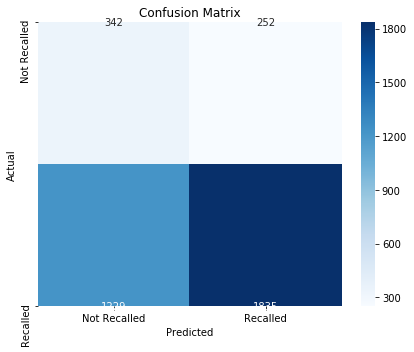

In [12]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recalled', 'Recalled'],
            yticklabels=['Not Recalled', 'Recalled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

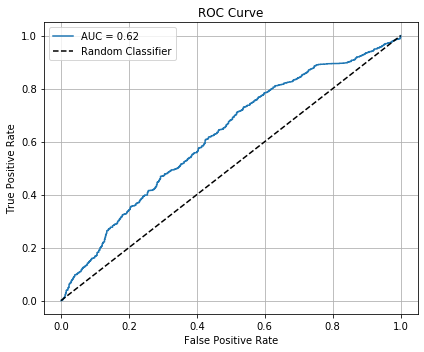

In [13]:
# STEP 9: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()